# Polymers

## Fancy fuckings innledning goes here

1 a)

Ved å lagre informasjonen i et N x 2 array, vil kjøretiden minke betraktelig. Siden vi bare er interresert i posisjonen til de N monomerene, og ikke hele gitteret, vil dette være den beste framgangsmåten. Vi oppretter et array med dimensjon N x 2, der hver rad inneholder informasjon om posisjonen til en monomer i polymeren. Den første kolonnen inneholder x-koordinaten til polymeren, og den andre y-koordinaten. 

TODO: Skriv akademisk

In [48]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist

In [49]:
# 1b)
def createPolymer(n):
    """Inputs a number n and returns a horizontal polymer"""
    polymer = np.zeros((n,2))
    polymer[:,0] = np.linspace(0,n-1,n)
    polymer[:,1] = n//2
    return polymer

1c)
En rotatsjon om endepunktene vil ikke gi energiendring. Energiendring kommer av vekselvirkninger mellom monomerer som ligger inntil hverandre, men ikke er nabo-monomerer i selve polynomet.
Altså er det kun energiendring om enten som monomerer ligger i en avstand 1 unna hverandre flyttes fra hverandre, eller motsatt, hele tiden uten å være naboer i polynomet.

TODO: Skriv akademisk

In [50]:
def visualize_polymer(polymer, title=""):
    # Calculate the minimum and maximum coordinates of the polymer
    min_x = int(np.min(polymer[:, 0]))
    max_x = int(np.max(polymer[:, 0]))
    min_y = int(np.min(polymer[:, 1]))
    max_y = int(np.max(polymer[:, 1]))

    # Calculate grid dimensions based on the polymer coordinates
    grid_width = max_x - min_x + 1
    grid_height = max_y - min_y + 1
    grid_size = int(np.max([grid_height, grid_width]))
    cmap = ListedColormap(['white'] + plt.cm.viridis.colors)

    # Initialize the grid with zeros
    grid = np.zeros((grid_size, grid_size))

    # Plot the polymer on the grid
    # TODO: Vurder å prøve å kaste forløkka på sjøen
    for i, (x, y) in enumerate(polymer):
        grid[int(y - min_y), int(x - min_x)] = i + 1

    # Visualize the grid
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(grid,  edgecolors='black', linewidth=0.5, cmap=cmap)
    plt.colorbar(label='Monomer ID')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    if title != "":
        plt.title(title)
    plt.show()

In [51]:
# 1e)

def isIntact(polymer, N):
    """Checks if a polymer is intact"""
    
    length = len(polymer)

    # Check if the length of the polymer is the same as when it was initialized. If it´s shorter, return false.
    if length != N:
        return False

    # Remove potential monomers in identical positions, and check if this shortens the polymer. If so, return false.
    uni_length = len(np.unique(polymer, axis=0))

    if uni_length != N:
        return False

    # Check if the distance between each adjacent monomer is 1, i.e. that the polymer chain is continous. If not, return false.
    # TODO: Vurder å prøve å fjerne for
    for i in range(N-1): 
        x_dist = np.abs(polymer[i+1][0]-polymer[i][0])
        y_dist = np.abs(polymer[i+1][1]-polymer[i][1])
        distance = x_dist + y_dist
        if distance != 1:
            return False
    return True

In [52]:
#TODO: Skriv om vha. rotasjonsmatrise. Bruk (blant annet) dette som svar i 1h)
def createDirectionList(polymerPart):
    """Input the part of a polymer that you want to rotate, and find what direction it rotates"""
    
    # Create a zero-array that is the length of the polymer part that you want to rotate (minus 1)
    dir = np.zeros(len(polymerPart)-1)
    
    for i in range(len(polymerPart)-1):
        d = polymerPart[i+1] - polymerPart[i]
        # Right
        if d[0] == 1 and d[1] == 0:
            dir[i] = 0
        # Up
        elif d[0] == 0 and d[1] == 1:
            dir[i] = 1
        # Left
        elif d[0] == -1 and d[1] == 0:
            dir[i] = 2
        # Down
        elif d[0] == 0 and d[1] == -1:
            dir[i] = 3
        else:
            raise ValueError("Not valid distance")
    return dir


In [53]:
def rotatePolymer(p, coord, clockwise=True):
    """Inputs a polymer, a point, and an optional boolean, and rotates the polymer around that point
    Rotates clockwise if clockwise is true or not given, counterclockwise if false."""
    
    rotatingBase = -1 #Hvorfor er denne -1? for-løkka under sjekker jo hvor det skal roteres om, og hvis det ikke er inni polymeret bør det vel ikke rotere? Og trenger vi break?
    polymer = np.copy(p)
    N = len(polymer)

    # Find index of monomer to rotate around
    for i in range(N):
        if np.array_equal(polymer[i], coord):
            rotatingBase = i
            break
    rotatingLeft = rotatingBase <= len(polymer)//2

    directionList = createDirectionList(polymer)
    if rotatingLeft:
        if clockwise:
            directionList[:rotatingBase] = (directionList[:rotatingBase] -1) % 4
        else:
            directionList[:rotatingBase] = (directionList[:rotatingBase] +1) % 4
    else:
        if clockwise:
            directionList[rotatingBase:] = (directionList[rotatingBase:] +1) % 4
        else:
            directionList[rotatingBase:] = (directionList[rotatingBase:] -1) % 4

    #IDEA: Calculate direction change for every polymer to be rotated. Then use this info to recalculate the position based of the rotation base.
    #print(directionList)

    if rotatingLeft:
        for i in range(rotatingBase - 1, -1, -1):
            polymer[i] = polymer[i+1]
            if directionList[i] == 0: # Right
                polymer[i][0] -= 1
            if directionList[i] == 1: # up
                polymer[i][1] -= 1
            if directionList[i] == 2: # left
                polymer[i][0] += 1
            if directionList[i] == 3: # down
                polymer[i][1] += 1
    else:
        for i in range(rotatingBase + 1, len(polymer)):
            polymer[i] = polymer[i - 1]
            if directionList[i - 1] == 0: # Right
                polymer[i][0] += 1
            if directionList[i - 1] == 1: # up
                polymer[i][1] += 1
            if directionList[i - 1] == 2: # left
                polymer[i][0] -= 1
            if directionList[i - 1] == 3: # down
                polymer[i][1] -= 1
    return polymer

In [54]:
#Rotate igjen
# Bruk i 1 h)

def rotatePolymer(polymer, coord, clockwise = True):
    """Inputs a polymer and rotates the short end in the direction specified around coord."""

    # Create a clockwise- or counterclockwise-rotation matrix, depending on the input.
    rotation_matrix =  np.array([[0, 1], [-1, 0]]) if clockwise else np.array([[0, -1], [1, 0]])

    # Find the index of the monomer you want the polymer to rotate about
    rotationCenterIdx = np.where((polymer == coord).all(axis=1))[0][0]

    # Move the rotation center to the origin before rotating
    translatedPolymer = polymer - coord

    # Make a copy of translatedPolymer to ensure no loss of data due to pass-by-reference used in np.arrays
    rotated_polymer = np.copy(translatedPolymer)

    # Check on what side of the polymer the monomer you rotate about is, so the shortest end always is the one that is rotated.
    if rotationCenterIdx <= len(polymer)//2:
        rotated_polymer[:rotationCenterIdx] = rotated_polymer[:rotationCenterIdx] @ rotation_matrix
    else:
        rotated_polymer[rotationCenterIdx + 1:] = rotated_polymer[rotationCenterIdx + 1:] @ rotation_matrix
    return rotated_polymer + coord

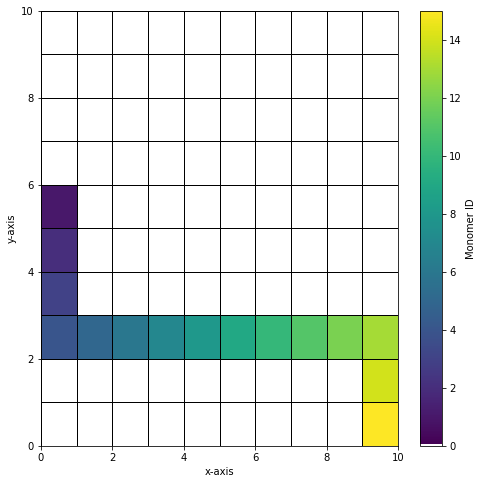

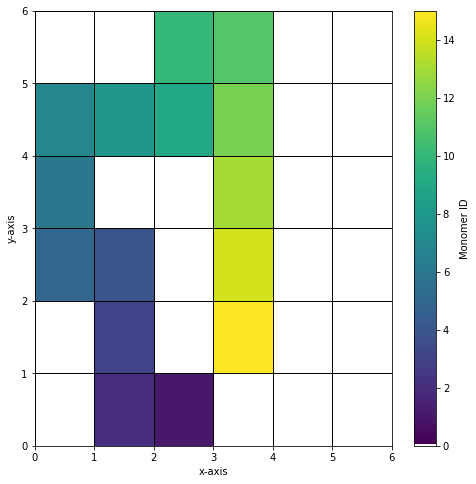

In [55]:
# 1g)

def testRotate(N, N_s):
    """Inputs a N and N_s and rotates a N long polymer N_s number of times, and outputs the last position and number of successful rotations"""
    
    # Create a polymer with given length, aswell as an empty array and a counter for number of succesfull rotations
    polymer = createPolymer(N)
    twisted_polymer = np.array([])
    succesRotations = 0

    # Twist the given polymer N_s times
    for i in range(N_s):

        # Find a random monomer to rotate about, and a random direction, either clockwise or counterclockwise
        rotateMonomer = np.random.randint(1, N+1)
        rotateMonomer = polymer[rotateMonomer - 1]
        clockwise = np.random.randint(1,3) == 1

        # Create a new twisted polymer, depending on the random monomer and direction given above
        twisted_polymer = rotatePolymer(polymer, rotateMonomer, clockwise)

        # Check if the twisted polymer is intact, and if so, this is the new polymer, add 1 to the counter, and use this polymer for the remaining iterations
        # If not, the next iteration will use the last valid polymer
        if isIntact(twisted_polymer, N) == True:
            succesRotations += 1 
            polymer = np.copy(twisted_polymer)
    
    return polymer, succesRotations

# Create two test-rotations for a polymer that is N=15 monomers long, one with Ns=4 and the other with Ns=1000
polymer4, successes4 = testRotate(15, 4)
polymer1000, sucesses1000 = testRotate(15, 1000)
# Visualize the end position of the two tests
visualize_polymer(polymer4)
visualize_polymer(polymer1000)


In [56]:
# TODO: Sett inn 1h her

In [57]:
#1i)

def successRot(N_s):
    """Inputs a number of attempted rotations, and returns number of successful rotations"""

    successRate = np.array([])

    # Create a for-loop for increasing N-values, where in each iteration the number of successful rotations are returned as a percentage,
    # and the percentage is appended to an array, and return this array
    for i in range(10, 600, 20):
        successes = testRotate(i, N_s)[1]
        percentage = successes * 100/N_s
        successRate = np.append(successRate, percentage)

    return successRate

In [58]:
xVals = np.arange(10, 600, 20)

yVals500 = successRot(500)
yVals1500 = successRot(1500)
yVals4000 = successRot(4000)

/var/folders/y3/1w5k7p493sl56cbk6014g7mw0000gn/T/ipykernel_57348/4287871246.py:5: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


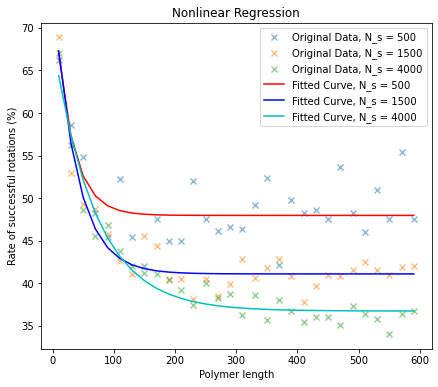

In [59]:
# Perform curve fitting
initial_guess = (1, 1, 1)

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt1, pcov1 = curve_fit(func, xVals, yVals500, p0=initial_guess)
popt2, pcov2 = curve_fit(func, xVals, yVals1500, p0=initial_guess)
popt3, pcov3 = curve_fit(func, xVals, yVals4000, p0=initial_guess)

# Extract optimized parameters
a_fit, b_fit, c_fit = popt1
d, e, f = popt2
g, h, i = popt3

# Generate y values using the fitted parameters
y_pred500 = func(xVals, a_fit, b_fit, c_fit)
y_pred1500 = func(xVals, d, e, f)
y_pred4000 = func(xVals, *popt3)

# Plot the original data and the fitted curve
plt.figure(figsize=(7,6))
plt.scatter(xVals, yVals500, marker="x", alpha=0.5, label='Original Data, N_s = 500')
plt.scatter(xVals, yVals1500, marker="x", alpha=0.5, label='Original Data, N_s = 1500')
plt.scatter(xVals, yVals4000, marker="x", alpha=0.5, label='Original Data, N_s = 4000')
plt.plot(xVals, y_pred500, 'r-', label='Fitted Curve, N_s = 500')
plt.plot(xVals, y_pred1500, 'b-', label='Fitted Curve, N_s = 1500')
plt.plot(xVals, y_pred4000, 'c-', label='Fitted Curve, N_s = 4000')
plt.xlabel('Polymer length')
plt.ylabel('Rate of successful rotations (%)')
plt.title('Nonlinear Regression')
plt.legend()
plt.show()

In [60]:
# 1j)

def calculateEnergy(polymer, V):
    b = cdist(polymer, polymer, 'cityblock') == 1
    energyMatrix = np.multiply(V,b)
    return np.sum(energyMatrix)/2

V = np.zeros([len(polymer1000),len(polymer1000)])
V[np.tril_indices_from(V,-2)] = -1
V[np.triu_indices_from(V,2)] = -1

print(f'Energy for polymer with 4 attempted rotations: {calculateEnergy(polymer4,V)}')
print(f'Energy for polymer with 1000 attempted rotations: {calculateEnergy(polymer1000,V)}') 

Energy for polymer with 4 tried rotations: 0.0
Energy for polymer with 1000 tried rotations: -1.0


In [61]:
#2a)
# TODO: Kan denne effektiviseres?

def metropolis(polymer, N_s, V, T):
    beta = 1/(k_B*T)
    N = len(polymer)
    E_arr = np.zeros(N_s)
    E = calculateEnergy(polymer, V)
    E_arr[0] = E
    i = 0
    while i < N_s:
        xRand = np.random.randint(1, len(polymer))
        twist_coords = polymer[xRand]
        clockwise = bool(np.random.randint(0,2))
        twisted_polymer = rotatePolymer(polymer,twist_coords, clockwise)
        if isIntact(twisted_polymer, N):
            E_new = calculateEnergy(twisted_polymer, V)
            if E_new < E or np.random.uniform() < np.exp(-beta*(E_new - E)):
                polymer = np.copy(twisted_polymer)
                E = E_new
            E_arr[i] = E
            i += 1
            
    return polymer, E_arr

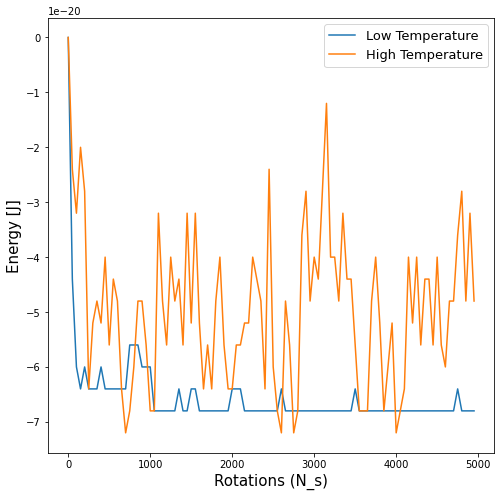

In [62]:
# 2b
# TODO: Fjern warnings

p1 = createPolymer(30)
p2 = np.copy(p1)
N_s = 5000
nonzero_E = -4e-21
k_B = 1.38e-23


V = np.zeros([len(p1),len(p1)])
V[np.tril_indices_from(V,-2)] = nonzero_E
V[np.triu_indices_from(V,2)] = nonzero_E

T_low = 75
T_high = 343

polymer_low, E_arr_low = metropolis(p1, N_s, V, T_low)
polymer_high, E_arr_high = metropolis(p2, N_s, V, T_high)

t = np.arange(0,len(E_arr_low))

plt.figure(figsize=(8,8))
plt.xlabel("Rotations (N_s)", fontsize=15)
plt.ylabel("Energy [J]", fontsize=15)
plt.plot(t[::50],E_arr_low[::50], label="Low Temperature")
plt.plot(t[::50],E_arr_high[::50], label="High Temperature")
plt.legend(fontsize=13)
plt.show()



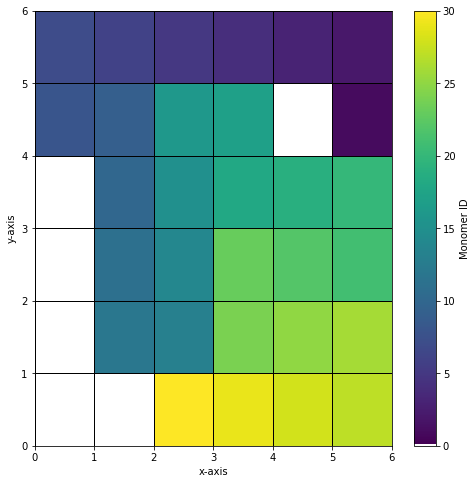

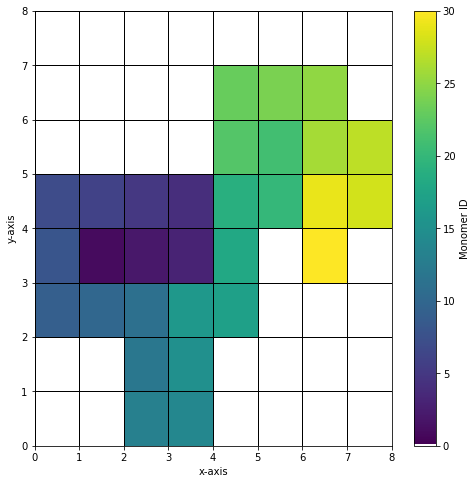

In [63]:
# 2c
visualize_polymer(polymer_low)
visualize_polymer(polymer_high)

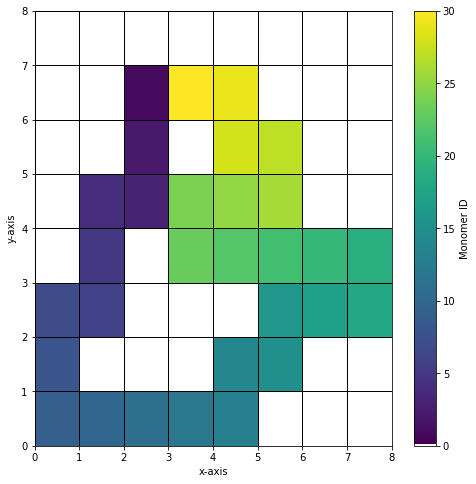

In [64]:
# 2d
#TODO: Denne matrisen stemmer ikke, diagonal != 0. Den er også lite interessant.
p3 = createPolymer(30)
V_d = np.zeros([30,30]) # Use V as a starting point
V_d[0][-1] = -100
V_d[-1][0] = -100

for i in range(1, len(p3//2 + 1)):
    V_d[i:-i, i:-i] *=10

polymer_d, E_d = metropolis(p3, 10000, V_d, 150)

visualize_polymer(polymer_d)

In [65]:
# 2e
# Her er vi usikre på om alt er riktig
def test(N_s):
    pol = createPolymer(30)
    Temperature = np.arange(10, 1000, 30)
    energyArray = np.zeros([33, N_s - 1000])

    for i in range(len(Temperature)):
        energyArray[i] = metropolis(pol, N_s, V, Temperature[i])[1][1000:]

    return energyArray

Temperature = np.arange(10,1000,30)

In [66]:
runNs1500 = test(1500)
runNs3000 = test(3000)
runNs6000 = test(6000)

In [ ]:
# TODO: Plott ved siden av hverandre, vurder å plotte ved siden av hverandre

meanRunNs1500 = np.mean(runNs1500, axis=1)
stdRunNs1500 = np.std(runNs1500, ddof=1, axis=1)

meanRunNs3000 = np.mean(runNs3000, axis=1)
stdRunNs3000 = np.std(runNs3000, ddof=1, axis=1)

meanRunNs6000 = np.mean(runNs6000, axis=1)
stdRunNs6000 = np.std(runNs6000, ddof=1, axis=1)

# Create figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot data on the first subplot
axs[0].errorbar(Temperature, meanRunNs1500, yerr=stdRunNs1500, fmt='-', capsize=3)
axs[0].plot(Temperature, meanRunNs1500)
axs[0].set_xlabel(("Temperature [K]"))
axs[0].set_ylabel("$\\langle E \\rangle$")
axs[0].set_title('N_s = 1500')

# Plot data on the second subplot
axs[1].errorbar(Temperature, meanRunNs3000, yerr=stdRunNs3000, fmt='-', capsize=3)
axs[1].plot(Temperature, meanRunNs3000)
axs[1].set_xlabel(("Temperature [K]"))
axs[1].set_ylabel("$\\langle E \\rangle$")
axs[1].set_title("N_s = 3000")

# Plot data on the third subplot
axs[2].errorbar(Temperature, meanRunNs6000, yerr=stdRunNs6000, fmt='-', capsize=3)
axs[2].plot(Temperature, meanRunNs6000)
axs[2].set_xlabel(("Temperature [K]"))
axs[2].set_ylabel("$\\langle E \\rangle$")
axs[2].set_title('N_s = 6000')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# 2f

T = 70 #K
N = 30 
N_s = 2000

def EnergyConstantT(T, N, N_s, V):
    i_arr = np.arange(0, N_s)
    plt.figure(figsize=(24, 12))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Number of rotations [t]", fontsize=25)
    plt.ylabel("Energi per step [E(t)]", fontsize=25)
    plt.title(f"Energi ved 10 metropolissimuleringer og konstant temperatur {T} K", fontsize=20)
    for i in range(1, 11):
        polymer = createPolymer(N)
        metro = metropolis(polymer, N_s, V, T)
        plt.plot(i_arr, metro[1], label = f"Simulation nr {i}")
    plt.legend(fontsize=15)

EnergyConstantT(T, N, N_s, V)

In [ ]:
# 2g

def getEuclideanDistance(polymer):
    return np.max(cdist(polymer, polymer, 'euclid'))

def metropolis_with_d(polymer, N_s, V, T):
    beta = 1/(k_B*T)
    N = len(polymer)
    E_arr = np.zeros(N_s)
    d_arr = np.zeros(N_s)
    E = calculateEnergy(polymer, V)
    E_arr[0] = E
    i = 0
    while i < N_s:
        xRand = np.random.randint(1, len(polymer))
        twist_coords = polymer[xRand]
        clockwise = bool(np.random.randint(0,2))
        twisted_polymer = rotatePolymer(polymer,twist_coords, clockwise)
        if isIntact(twisted_polymer, N):
            E_new = calculateEnergy(twisted_polymer, V)
            if E_new < E or np.random.uniform() < np.exp(-beta*(E_new - E)):
                polymer = np.copy(twisted_polymer)
                E = E_new
            E_arr[i] = E
            d_arr[i] = getEuclideanDistance(polymer)
            i += 1

    return polymer, E_arr, d_arr
            


In [ ]:
# Define the interval
lower_bound = -6e-21
upper_bound = -2e-21

# Generate a random upper triangular matrix within the specified interval
random_matrix = (upper_bound - lower_bound) * np.random.rand(25, 25) + lower_bound
upper_triangular = np.triu(random_matrix, 1)

# Construct the symmetrical matrix by copying the upper triangular part to the lower triangular part
symmetrical_matrix = upper_triangular + upper_triangular.T

# Set the diagonal elements and the diagonals on each side of the main diagonal to zero
for i in range(25):
    symmetrical_matrix[i, i] = 0
    if i > 0:
        symmetrical_matrix[i, i-1] = 0
        symmetrical_matrix[i-1, i] = 0


In [ ]:
polly = createPolymer(25)
dArray = np.zeros([33, 1000])
eArray = np.zeros([33, 1000])
Temperature = np.arange(10, 1000, 30)

for i in range(len(Temperature)):
    dArray[i] = metropolis_with_d(polly, 2000, symmetrical_matrix, Temperature[i])[2][1000:]
    eArray[i] = metropolis_with_d(polly, 2000, symmetrical_matrix, Temperature[i])[1][1000:]


meansDArray = np.array([np.mean(subarray) for subarray in dArray])
meansEArray = np.array([np.mean(subarray) for subarray in eArray])


# Create figure and axes
fig, ax1 = plt.subplots()

# Plot on the first axes
ax1.plot(Temperature, np.abs(meansEArray), '-', label='Mean energy', color="crimson")
ax1.set_xlabel('Temperature')
ax1.set_ylabel('$\\langle E \\rangle$', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')
ax1.legend(loc='upper left')

# Create a second axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(Temperature, meansDArray, '-', label='Mean diameter', color="darkslateblue")
ax2.set_ylabel('$\\langle d \\rangle (T)$', color='darkslateblue')
ax2.tick_params(axis='y', labelcolor='darkslateblue')
ax2.legend(loc='lower right')

plt.show()

In [ ]:
def vetikkehvakalle(V, N_s, N, T, polymer):
    Temperature = np.arange(T, 10, -30)
    p = np.copy(polymer)
    d_arr = np.zeros(len(Temperature))
    for i in range(len(Temperature)):
        p, E, d = metropolis_with_d(p, N_s, V, Temperature[i])
        d_arr[i] = np.mean(d)
    visualize_polymer(p)
    return d_arr, Temperature

d_arr, T = vetikkehvakalle(V, N_s, 30, 1000, createPolymer(30))


In [ ]:
def func2(x,a,b,c):
    return 1-a*np.exp(-b*x)+c
#scatter eller lineplot? Spør på veiledning
initial_guess = (1, 0.01, 1)

popt3, pcov3 = curve_fit(func2, T, d_arr, p0=initial_guess)
a_fit, b_fit, c_fit = popt3
predictedY = func2(T, a_fit,b_fit,c_fit)

plt.scatter(T, d_arr, marker="x", alpha=0.7, color="darkorange", label="Original Data")
plt.plot(T, predictedY, '-', color="seagreen", label="Fitted Curve")
plt.xlabel('x')
plt.ylabel('y')
plt.title("Nonlinear Regression")
plt.legend()
plt.show()